In [241]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import cv2
import h5py
import pickle
import sys
import scipy.io
import re
from scipy.spatial import distance
from scipy.stats import zscore
from scipy.stats import zmap
%matplotlib inline

dir = r"D:\2024-01-03_ALC6_day1"
data_path = os.path.join(dir, '02-processed')
npy_path = os.path.join(dir, '00-npy files')
raw_path = os.path.join(dir, '01-raw')
h5_path = os.path.join('D:/np_analysis', 'data_multimice.h5')


## 0.1 Function to import phy-adjusted kilosort data.

In [133]:
def importphy(folderpath, tipDepth=4000, sampleRate=30000):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to kilosort output
        2. `tipDepth` - int/float, depth of the shank tip in microns (Reading of D axis given by sensapex micromanipulator)
        3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `goodSpikes` - ndarray of clusters (unit identities of spikes)
        3. `goodSamples` - ndarray of spike samples (time of spike)
        4. `goodTimes` - ndarray of spike times (in s)
        5. `clusterIDs` - ndarray of unit index as listed in the Kilosort/Phy output
        6. `goodIDs` - ndarray of all units included in goodSpikes
        7. `depths` - ndarray of recording site depth, order match with `clusterID` (counting the depth of shank)
        8. `nSpikes` - ndarray of number of spikes 

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
        2. `depthIndices` - index of good units in the order of their depth
        3. `layers` - the cortical layer to which the depth corresponds
        4. 'waveforms of unit at its best site'
    """
    # parameters
    tipLength = 175 # the tip length of neuropixel 1.0 [unit: µm]

    # import the Kilosort data
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # apply label from manual curation 
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    # store units with good qualities
    try:
        goodIDs = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        goodIDs = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # compute the depth
        siteDepth = tipDepth - tipLength - np.array(clusterInfo['depth'])
        if any(depth < 0 for depth in siteDepth):
            print("Warning: Negative depth value found, changing to 0.")
            siteDepth = [0 if depth < 0 else depth for depth in siteDepth]

    # write the output
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['goodSpikes'] = spikeClusters[np.array([n in goodIDs for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in goodIDs for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['clusterIDs'] = np.array(clusterInfo['cluster_id']) ## to get a list of cluster ids
    outDict['goodIDs'] = goodIDs
    outDict['depths'] =  siteDepth
    outDict['nSpikes'] = np.array(clusterInfo['n_spikes']) ## to get number of spikes 
    #outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth

    # print the number of good neurons
    print("Number of neurons passing the quality check: {}".format(len(goodIDs)))

    # report the sampling frequency
    print("Sampling frequency: {} Hz.".format(outDict['sampleRate']))
    
    return outDict

In [242]:
spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)

goodSamples = np.array(spikeDict['goodSamples'])
goodSpikes = np.array(spikeDict['goodSpikes'])
goodTimes = np.array(spikeDict['goodTimes'])
sampleRate = np.array(spikeDict['sampleRate'])
depths = np.array(spikeDict['depths'])
clusterIDs = np.array(spikeDict['clusterIDs'])

Number of neurons passing the quality check: 201
Sampling frequency: 30000 Hz.


In [192]:
def importnpy(dir):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to folder containing numpy arrays from NP_Optical trials
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `mechTrialForce` - array of all successfully recorded trials and their forces
        3. `mechTrials` - int of the number of successfully recorded mech trials
        

        ## Not yet implemented
        

    """
    import os
    import numpy as np
    import re

    data_path = os.path.join(dir, '02-processed').replace('\\', '/')
    npy_path = os.path.join(dir, '00-npy files').replace('\\', '/')
    raw_path = os.path.join(dir, '01-raw').replace('\\', '/')
    


    def mechTrialForce ():
        npy_files = [item for item in os.listdir(npy_path)]
        mech_files = [file for file in npy_files if 'mC_ai_data' in file]
        
        #1 sorting function to extract trial forces
        def sort_key(file):
            match = re.search(r'_(\d+).npy$', file)
            return int(match.group(1)) if match else float('inf')

        # Sort the mech trial files using the custom sorting function
        sorted_files = sorted(mech_files, key=sort_key)

        #extract forces in the proper trial order
        npy_Forces = []
        for sorted_file in sorted_files:
            match = re.search(r'_(\d+)mN_', sorted_file)
            force = int(match.group(1)) if match else None
            npy_Forces.append(force)


        #2 Extract trial numbers from successfully recorded mech trials (OpenEphys)
        recording_path = os.path.join(raw_path, '1-mechanical').replace('\\', '/')
        recordings = [item for item in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, item))]
        recordings = sorted(recordings, key=lambda x: int(''.join(filter(str.isdigit, x))))

        # regex search of recordings for successfully recorded mech trials
        pattern = re.compile(r'recording(\d+)')
        successfulRecordings = []
        for recording in recordings:
            match = pattern.search(recording)
            if match:
                successfulRecordings.append(int(match.group(1)))

        # sort/return successfulRecordings list
        successfulRecordings = sorted(successfulRecordings)

        #list and export the forces for only the successfully recorded mech trial files
        mechTrialForce = [npy_Forces[i - 1] for i in successfulRecordings]

        return mechTrialForce

    
    try:
        mechTrialForce = mechTrialForce()
    except FileNotFoundError:
        print("Mech trial files not found. Array creation for mechTrialForce failed.")
    except Exception as e:
        print("An error occurred:", e)


    #Exports
    outDict = {}
    try:
        outDict['sampleRate'] = sampleRate
        outDict['mechTrialForce'] = mechTrialForce
        outDict['mechTrials'] = len(mechTrialForce)
    except Exception as e:
        print("An error occurred:", e)


    return outDict

In [243]:
npyDict = importnpy(dir)

mechTrialForce = npyDict['mechTrialForce']


print(mechTrialForce)
print(len(mechTrialForce))

[50, 200, 50, 200, 200, 200, 200, 50, 200, 50, 200, 100, 50, 200, 100, 50, 100, 200, 50, 100, 200, 200, 200, 200, 200, 200, 100, 200, 100, 100, 200, 100, 200, 100, 100, 200, 100, 50, 50, 100, 50, 50, 50, 50, 50, 200, 200, 100, 50, 50, 100, 200, 50, 50, 100, 200, 100, 100, 100, 200, 100, 50, 100, 100, 100, 100, 200, 100, 50, 50, 100, 100, 100, 50, 50, 50, 200, 100, 200, 200, 200, 200, 100, 200, 200, 100, 200, 50, 50, 200, 200, 100, 200, 200, 50, 200, 100, 200, 100, 200, 100, 200, 50, 100, 50, 200, 50, 100, 50, 100, 50, 100, 50, 100, 50, 100, 100, 100, 200, 50, 50, 200, 50, 200, 100, 50, 50, 50, 50, 200, 100, 50, 50, 200, 200, 200, 200, 200, 50, 200, 50, 50, 100, 100, 200, 200, 100, 100, 200, 200, 50, 100, 50, 50, 100, 50, 100, 50, 200, 200, 50, 100, 50, 50, 50, 50, 200]
167


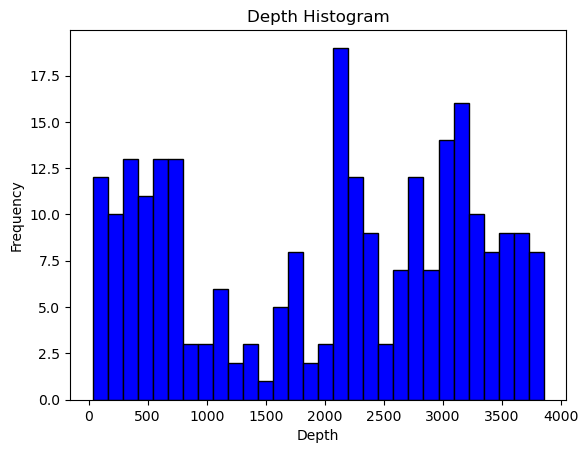

In [244]:
# Plotting the histogram
plt.hist(depths, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Depth Histogram')

# Display the histogram
plt.show()

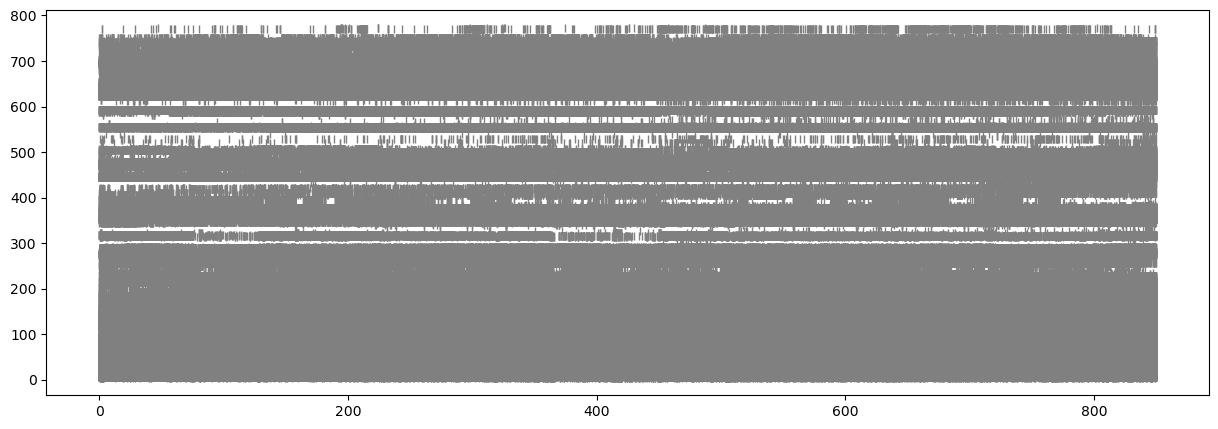

In [ ]:
ltime = 0 # in seconds
rtime = 850 # in seconds

#plt.plot(goodtimes,goodspikes,'|')
plt.figure(figsize=(15,5))
plt.plot(goodTimes[(goodTimes > ltime) & (goodTimes < rtime)],goodSpikes[(goodTimes > ltime) & (goodTimes < rtime)],'|',color='gray')

## 0.2 Plotting for mechanical stimultion

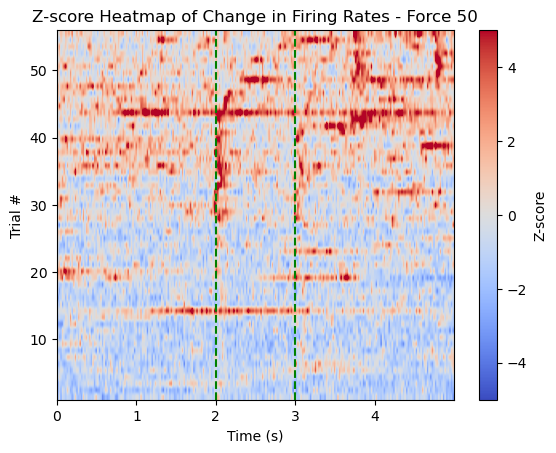

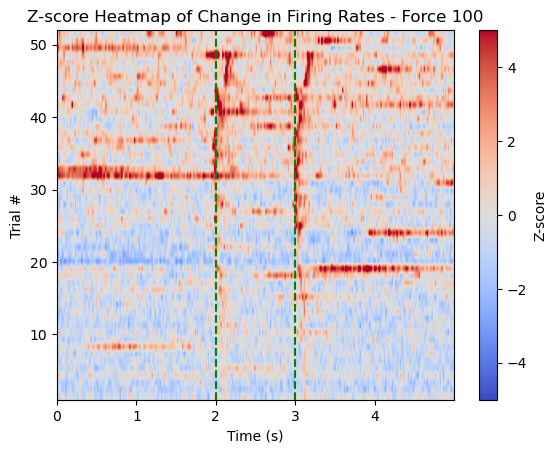

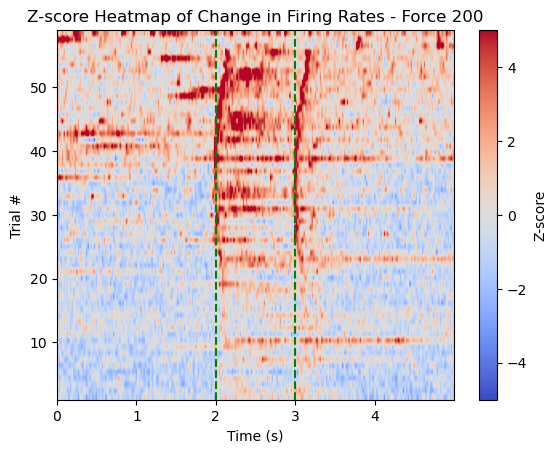

In [252]:
#Plot all mech trials (separated by force)
# Define trial parameters
trial_duration = 4.997  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = len(mechTrialForce)
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # Find indices within range
    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]



# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(mechTrialForce)

for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(mechTrialForce == force)[0]
    force_change_in_firing_rates = change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    
    # Plotting
    time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}')
    plt.show()

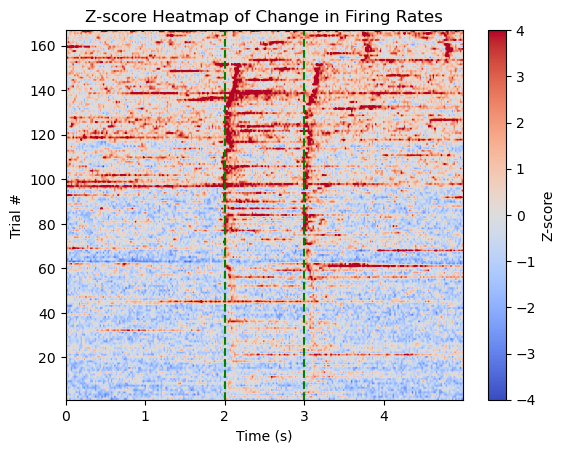

In [253]:
#Plot all mech trials (unseparated by force)
# Z-score the change in firing rates
#z_scored_change = zscore(change_in_firing_rates, axis=1)
z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-4, vmax=4)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

#takes about 1.5 minutes

[ 21  27  47  50  66  68  83  87 127 150 158 166 187 191 199 202 205 208
 209 210 211 212 213 216 217 218 220 221 223 224 225 228 229 231 233 237
 244 245 246 253 259 272 285 351 396 415 439 446 452 471 494 507 516 520
 531 539 541 554 555 558 575 599 600 602 618 625 628 632 639 646 649 650
 652 653]


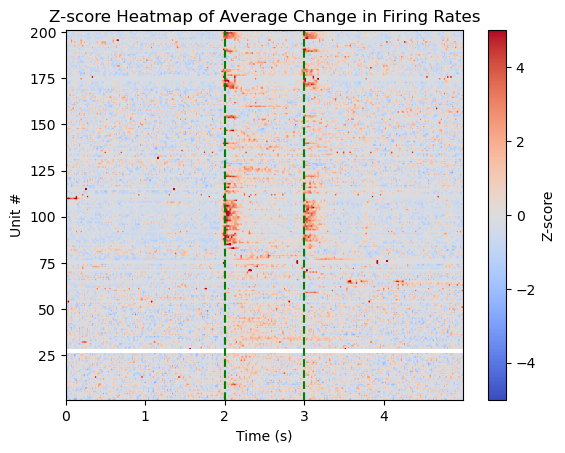

In [254]:
#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(goodSpikes)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * trial_duration)
        end_index = (j + 1) * int(sampleRate * trial_duration)

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)

plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unique_units)],
           cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')


# Extract units with z-scores over 2 between 1.9 and 2.1 seconds and plot z-maps
time_window_start = int(2 / bin_factor)
time_window_end = int(2.4 / bin_factor)
selected_units = unique_units[np.any(z_scored_change[:, time_window_start:time_window_end] > 3, axis=1)].astype(int)

print(selected_units)
plt.show()


In [255]:
#get an array of the depths of selected_units that can be referenced to split later by depth (cortical vs thalamic)
# Create a boolean mask for goodSpikes in clusterIDs
bool_mask = np.isin(clusterIDs, selected_units)
# Use the mask to extract depths for goodSpikes
selected_unit_depths = depths[bool_mask].astype(int)

In [256]:
cortical_selected_units = selected_units[selected_unit_depths < 2000]
thalamic_selected_units = selected_units[selected_unit_depths >= 2000]
print(cortical_selected_units)
print(thalamic_selected_units)

[187 191 199 202 205 208 209 210 211 212 213 216 217 218 220 221 223 224
 225 228 229 231 233 237 244 245 246 253 259 272 285 351 396 439 446 531
 539 541 554 555 558 575 599 600 602 625 628 632 646 649 650 652 653]
[ 21  27  47  50  66  68  83  87 127 150 158 166 415 452 471 494 507 516
 520 618 639]


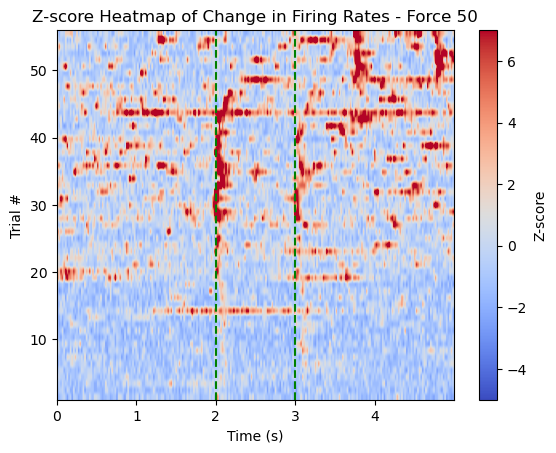

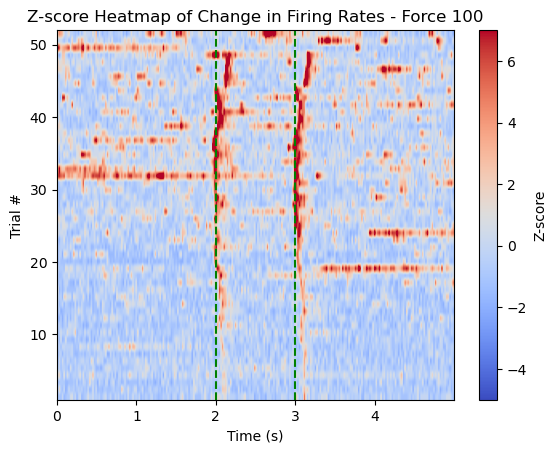

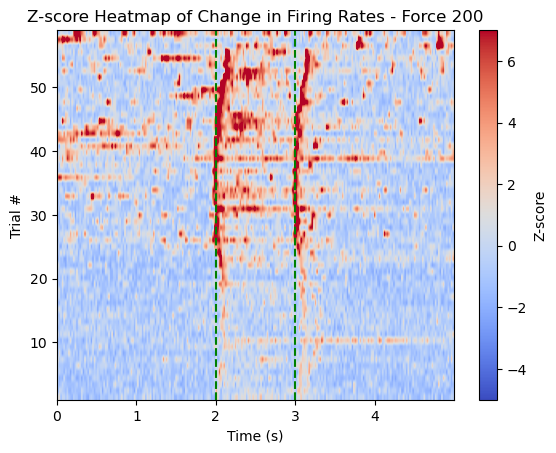

In [257]:
# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    #Find indices within range
    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
    #                                         & (np.searchsorted(goodSamples, start_index, 'left') 
    #                                         < np.searchsorted(goodSamples, end_index, 'right'))]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]



# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(mechTrialForce)

for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(mechTrialForce == force)[0]
    force_change_in_firing_rates = change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    #z_scored_change = (change_in_firing_rates - baseline_firing_rates.mean(axis=0, keepdims=True)) / baseline_firing_rates.std(axis=0, ddof=1, keepdims=True)

    
    # Plotting
    time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=7)  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}')    
    plt.show()

    #print(baseline_firing_rates[:,0])

In [177]:
with h5py.File(h5_path, 'a') as file:
    # List all groups and datasets in the root
    print("Groups and datasets in the root:")
    for name in file:
        print(name)

    # # Optionally, list the contents of a specific group (replace 'group_name' with your group name)
    # group_name = 'your_group_name'
    # if group_name in file:
    #     print(f"\nContents of '{group_name}':")
    #     for name in file[group_name]:
    #         print(name)

    # # Remove a group (replace 'group_to_remove' with your group name)
    # group_to_remove = 'ALC6_day4'
    # if group_to_remove in file:
    #     del file[group_to_remove]
    #     print(f"\n'{group_to_remove}' has been removed.")
    # else:
    #     print(f"\n'{group_to_remove}' not found.")

Groups and datasets in the root:
ALC4_day2
ALC4_day3
ALC4_day4
ALC6_day1
ALC6_day2
ALC6_day3
ALC6_day4


In [195]:
## Saving h5 data for each mouse as you get it
# Helper function to save all data
def save_data_to_group(mouse_group, data_name, data):
    if data_name in mouse_group:
        # mouse_group[data_name].resize((len(mouse_group[data_name]) + len(data),))
        # mouse_group[data_name][-len(data):] = data
        print(f'{data_name} already exists for data group {mouse_group}.')
        
    else:
        mouse_group[data_name] = data

# Extract mouse_name and exp_day
pattern = r"_([A-Za-z0-9]+)_(day\d+)"
match = re.search(pattern, dir)
if match:
    mouse_name = match.group(1)
    exp_day = match.group(2)

    print("Mouse Name:", mouse_name)
    print("Day:", exp_day)
else:
    print("Pattern not found in the 'dir' string.")

# data dict to-be-saved
data_to_save = {
    'sampleRate': sampleRate,
    'goodSpikes': goodSpikes,
    'goodSamples': goodSamples,
    'goodTimes': goodTimes,
    'depths': depths,
    'clusterIDs': clusterIDs,
    'selected_units': selected_units,
    'selected_unit_depths': selected_unit_depths,
    'cortical_selected_units': cortical_selected_units,
    'thalamic_selected_units': thalamic_selected_units,
    'mechTrialForce': mechTrialForce
    # Add more datasets as needed
}

with h5py.File(h5_path, 'a') as file:
    mouse_name = f'{mouse_name}_{exp_day}'

    # Create or update the group for the current mouse
    if mouse_name in file:
        mouse_group = file[mouse_name]
    else:
        mouse_group = file.create_group(mouse_name)

    # Create or update datasets for the additional data
    for data_name, data in data_to_save.items():
        save_data_to_group(mouse_group, data_name, data)


Mouse Name: ALC4
Day: day1


TypeError: Object dtype dtype('O') has no native HDF5 equivalent

In [ ]:
#How to open stored data

# Open the HDF5 file in read mode
with h5py.File('data_multimice.h5', 'r') as file:
    # Initialize an empty list to store the goodSpikes data
    all_goodSpikes = []

    # Iterate over mice
    for mouse_name in file.keys():
        # Check if 'goodSpikes' dataset exists in the current mouse group
        if 'goodSpikes' in file[mouse_name]:
            # Append the goodSpikes data to the list
            all_goodSpikes.append(np.array(file[mouse_name]['goodSpikes']))

    # Concatenate all goodSpikes data to create a single array
    combined_goodSpikes = np.concatenate(all_goodSpikes, axis=0)

# Now, combined_goodSpikes contains all the goodSpikes data from each mouse
print(combined_goodSpikes)

## 0.4 Plotting for physio experiment

In [296]:
settings = {
    'task_name' : 'acquireRecField',

    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording
    
    'Fs': 30000,  # in samples/s
    'xV': 7.8, # in V.
    'yV': 3.2, # in V.

    'stepV' : .05, # in Volts. Increment of voltage to be stepped for mirror
    'time_per_region' : 0.03, # in seconds. Duration to hold mirrors in place for each region
    'trial_repeats' : 10 # number of times each region should be sampled (default = 10)
}


# set mirror x_out and y_out arrays within the specified voltage range and increments
xminV = settings['xV'] - 0.5
xmaxV = settings['xV'] + 0.5
yminV = settings['yV'] - 0.5
ymaxV = settings['yV'] + 0.5
x_out_values = np.arange(xminV, xmaxV, settings['stepV'])
y_out_values = np.arange(yminV, ymaxV, settings['stepV'])

# create matrix for all possible combinations of x_out and y_out
all_combinations = np.array(np.meshgrid(x_out_values, y_out_values)).T.reshape(-1, 2)
trial_duration = len(all_combinations**2) * settings['time_per_region'] * settings['trial_repeats'] # in seconds
print(trial_duration*30000)

3780000.0


In [276]:
settings = {
    'task_name' : 'physiologicalLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'trace_oi' : 4, # number (X) for trace of interest from "SA-LTMR example traces/saltmr_trace{X}.npy"
    'laser_duration' : 0.0003,  # seconds
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}

# calculate trial_duration and load example trace_array
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))
print(trial_duration)

trace_array = np.load(r'C:\Users\aewor\Documents\GitHub\NP_Analysis\NP_Optical\SA-LTMR example traces\saltmr_trace{}.npy'.format(settings['trace_oi']))
# Assign trains of laser pulses in the same firing pattern as the trace_array empirical template
train_onsets = np.arange((settings['trial_buffer']), (trial_duration), ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']
laser_onsets = np.round(trace_array * settings['Fs']).astype(int)

print(train_onsets)
print(laser_onsets)

277.0
[  30000.  195000.  360000.  525000.  690000.  855000. 1020000. 1185000.
 1350000. 1515000. 1680000. 1845000. 2010000. 2175000. 2340000. 2505000.
 2670000. 2835000. 3000000. 3165000. 3330000. 3495000. 3660000. 3825000.
 3990000. 4155000. 4320000. 4485000. 4650000. 4815000. 4980000. 5145000.
 5310000. 5475000. 5640000. 5805000. 5970000. 6135000. 6300000. 6465000.
 6630000. 6795000. 6960000. 7125000. 7290000. 7455000. 7620000. 7785000.
 7950000. 8115000. 8280000.]
[  342   737  1137  1574  3133  4118  4672  5851  7837  8130  8568  9518
 11116 11554 12052 14364]


In [ ]:
settings = {
    'task_name' : 'pulsedLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'laser_duration' : 0.0003,  # seconds
    'laser_frequency' : 40, # Hz (for sustained pulse, equate to settings['Fs']). **Run 5, 20, and 40Hz for full set**
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}


# calculate trial_duration
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))

train_onsets = np.arange((settings['trial_buffer']), (trial_duration), ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']

intervals = []

for i in range(len(train_onsets)-1):
    interval = train_onsets[i+1] - train_onsets[i]
    intervals.append(interval)

print(train_onsets)
print(trial_duration*30000)
print(np.unique(intervals))
print(165000/30000)

[  30000.  195000.  360000.  525000.  690000.  855000. 1020000. 1185000.
 1350000. 1515000. 1680000. 1845000. 2010000. 2175000. 2340000. 2505000.
 2670000. 2835000. 3000000. 3165000. 3330000. 3495000. 3660000. 3825000.
 3990000. 4155000. 4320000. 4485000. 4650000. 4815000. 4980000. 5145000.
 5310000. 5475000. 5640000. 5805000. 5970000. 6135000. 6300000. 6465000.
 6630000. 6795000. 6960000. 7125000. 7290000. 7455000. 7620000. 7785000.
 7950000. 8115000. 8280000.]
8310000.0
[165000.]
5.5


In [234]:
physio = r"D:\2024-01-03_ALC6_day1\00-npy files\physioLaser_20240103_134825_ao_data.npy"
physfile = np.load(physio)
print(len(physfile[0]))
print(((len(physfile[0])/30000)-2)/5)

8160000
54.0


In [235]:
acrec = r"D:\2024-01-03_ALC6_day1\00-npy files\acRecField_20240103_134321_ao_data.npy"
acrecfile = np.load(acrec)
print(len(acrecfile[0]))
print(((len(acrecfile[0])/30000)-2)/5)

3600000
23.6


In [314]:
try:
    mech_duration = len(mechTrialForce) * 4.998 * 30000 #duration in samples
except TypeError:
    #if len(mechTrialForce is incalculable, it is a length of 0)
    mech_duration = 0 * 4.998 * 30000 #duration in samples

acRecField_duration = 3600000 #duration in samples
physio_duration = 8160000 #duration in samples

physio_start = mech_duration + acRecField_duration #start sample number
physio_end = physio_start + physio_duration #end sample number

physio_start_index = physio_start #+ int(1 * 30000) #add in buffer time


pulse_start = physio_start + physio_duration
pulse_end = pulse_start + physio_duration
print(physio_start_index)


28639980.0


In [326]:
#physio trial z-score calculations
# Define trial parameters
trial_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * trial_duration) + physio_start_index

    #trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]
    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

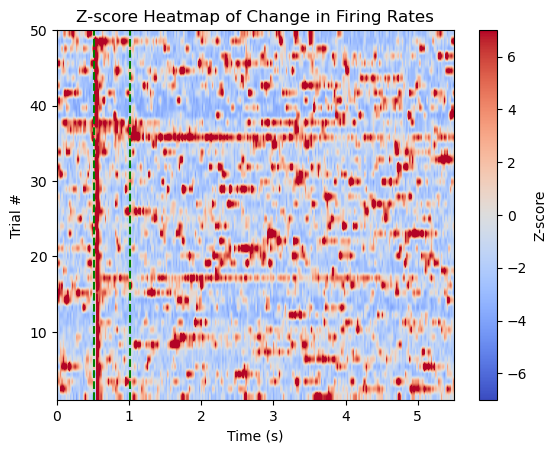

In [327]:
# Z-score the change in firing rates
#z_scored_change = zscore(change_in_firing_rates, axis=1)
z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-7, vmax=7)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = 15342/30000
hold_duration = 0.5
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

In [332]:
#pulse trial z-score calculations
# Define trial parameters
trial_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 150
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + pulse_start
    end_index = (i + 1) * int(sampleRate * trial_duration) + pulse_start

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

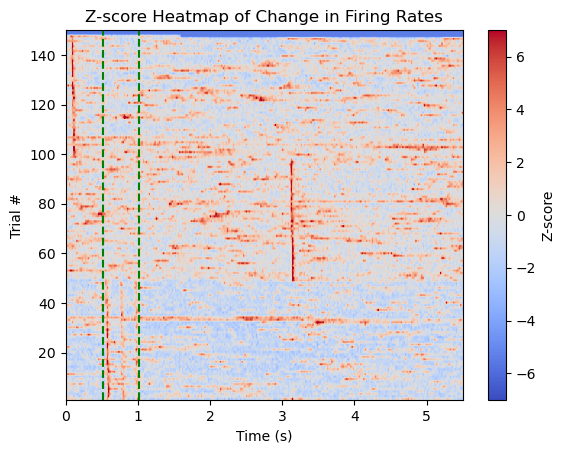

In [346]:
# Z-score the change in firing rates
#z_scored_change = zscore(change_in_firing_rates, axis=1)
z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-7, vmax=7)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = 15342/30000
hold_duration = 0.5
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

# stimulation_onset = (342+90000+3000)/30000
# hold_duration = 0.5
# plt.axvline(x=stimulation_onset, linestyle='--', color='blue', label='Stimulation Onset')
# plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='blue', label='Ramp Down')

# stimulation_onset = (3000)/30000
# hold_duration = 0.5
# plt.axvline(x=stimulation_onset, linestyle='--', color='black', label='Stimulation Onset')
# plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='black', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

In [18]:
#y axis is units instead of trials
# Define trial parameters
trial_duration = 5  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 172
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))  # Adjusted size
stimulation_signal = np.zeros((num_trials, int(sampleRate * trial_duration)))

# Create a dictionary to store firing rates for each unit
unit_firing_rates = {}
unit_baseline_rates = {}

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * trial_duration) + physio_start_index


    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]
    unique_units = np.unique(trial_spikes_all_units)

    # Calculate firing rates for each unit using np.histogram
    for unit_id in unique_units:
        unit_spikes = trial_spikes_all_units[trial_spikes_all_units == unit_id]

        firing_rates, bins = np.histogram(unit_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))
        unit_firing_rates.setdefault(unit_id, []).append(firing_rates[:num_bins])

        # Calculate the average firing rate from 2 seconds to the end
        baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
        unit_baseline_rates.setdefault(unit_id, []).append(baseline_firing_rate[:num_bins])

#takes about 1 minute

In [25]:
# Calculate the average change in firing rate for each unit across trials
average_unit_firing_rates = {unit_id: np.mean(unit_rates, axis=0) for unit_id, unit_rates in unit_firing_rates.items()}
average_unit_baseline_rates = {unit_id: np.mean(base_rates, axis=0) for unit_id, base_rates in unit_baseline_rates.items()}

# Convert the dictionary values to a 2D array for plotting
average_change_in_firing_rates = np.array(list(average_unit_firing_rates.values()))
average_change_in_baseline_rates = np.array(list(average_unit_baseline_rates.values()))

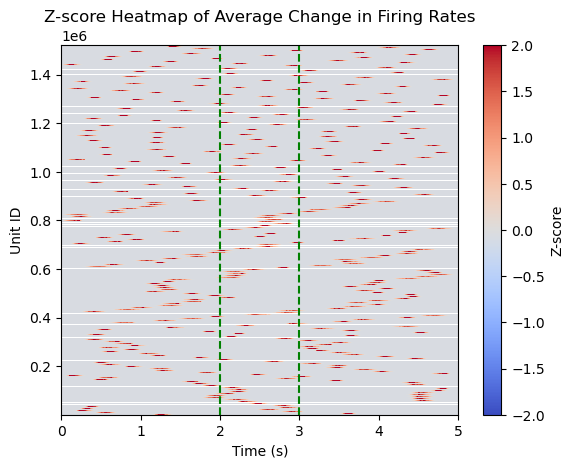

In [26]:
# Z-score the change in firing rates
#z_scored_change = zmap(average_change_in_firing_rates, average_change_in_baseline_rates, axis=0)
z_scored_change = zscore(average_change_in_firing_rates, axis=1)


# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
unit_axis = list(average_unit_firing_rates.keys())

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unit_axis)], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap


# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')
plt.show()